Running simulation with CFL Safety Checks...
Iteration 0: Max Change = 0.153955
Iteration 10: Max Change = 0.204387
Iteration 20: Max Change = 0.177931
Iteration 30: Max Change = 0.251315
Iteration 40: Max Change = 0.178440
Iteration 50: Max Change = 0.187940
Iteration 60: Max Change = 0.126358
Iteration 70: Max Change = 0.119889
Iteration 80: Max Change = 0.098909
Iteration 90: Max Change = 0.106036
Checking Mass Conservation...
Start Mass: 0.9521
End Mass:   0.9524


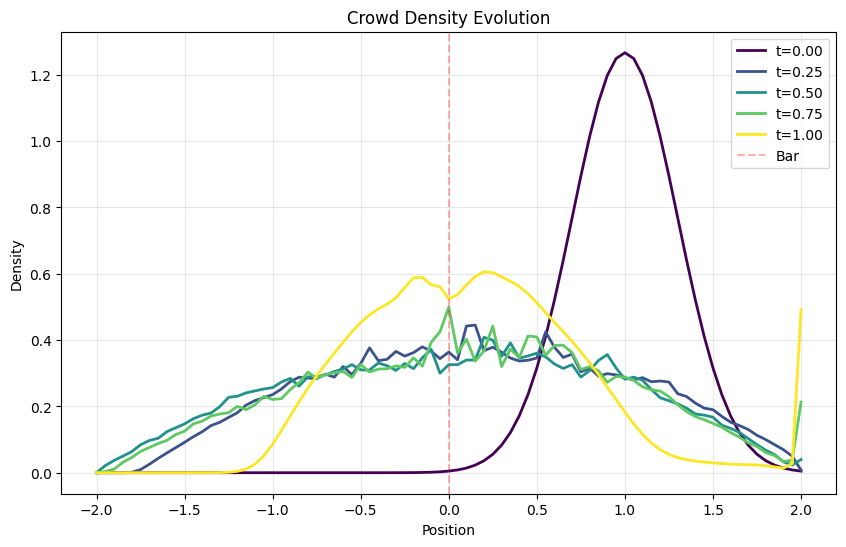

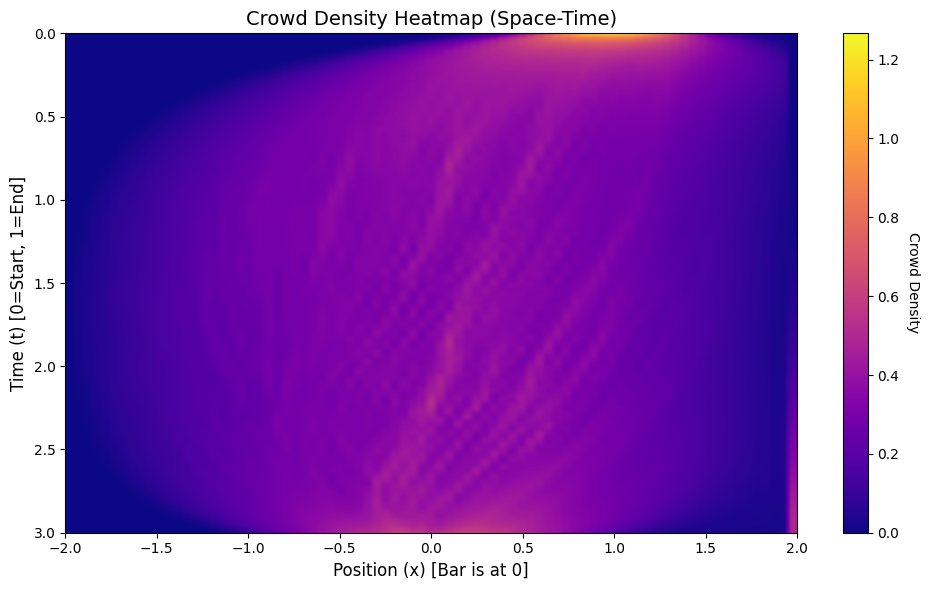

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Input parameter class

class Configuration:
    # Space and time min max
    X_MIN, X_MAX = -2.0, 2
    T_MIN, T_MAX = 0.0, 3.0

    # Number of x and t points
    NX = 81
    NT = 1500

    # viscosity
    NU = 0.015

    # Congestion 
    XI = 25

    # Attraction terms
    C_TERM = 2.0 # Cost of not getting to position in time
    C_RUN = 2 # Cost of not being at exactly the center

    MAX_ITER = 100
    ALPHA = 0.03 # Damping factor

    # Thirst parameters
    THIRST_ALPHA = 0.01 # Thirst growth factor
    BAR_RADIUS = 0.1 # Size of bar (reset zone)
    C_THIRST = 2.0 # Cost of Thirst

cfg = Configuration()

# Grid setup
dt = (cfg.T_MAX - cfg.T_MIN) / cfg.NT
dx = (cfg.X_MAX - cfg.X_MIN) / (cfg.NX - 1)
x_grid = np.linspace(cfg.X_MIN, cfg.X_MAX, cfg.NX)

#initialising thirst (all agents start at 0) also thirst instantly resets
thirst_field  = np.zeros((cfg.NT, cfg.NX))


# Some useful functions 
def get_terminal_cost(x):
    return cfg.C_TERM * (x**2)

def get_initial_distribution(x):
    sigma = 0.3 # Standard deviation
    mu = 1.0 # Starting position
    dist = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)
    return dist




# Solving the HJB part
# Please dont ask me about this I found it on github
def solve_hjb_backward(m_field, u_terminal):
    u = np.zeros((cfg.NT, cfg.NX))
    u[-1, :] = u_terminal
    
    x_coords = np.linspace(cfg.X_MIN, cfg.X_MAX, cfg.NX)
    
    for n in range(cfg.NT - 2, -1, -1):
        u_next = u[n + 1, :]
        
        # --- Update running cost with thirst at this time step ---
        running_cost_grid = cfg.C_RUN * (x_coords**2) + cfg.C_THIRST * thirst_field[n, :]
        
        # Gradient calculation
        d_u_dx = np.zeros_like(u_next)
        d_u_dx[1:-1] = (u_next[2:] - u_next[:-2]) / (2 * dx)
        
        d2_u_dx2 = np.zeros_like(u_next)
        d2_u_dx2[1:-1] = (u_next[2:] - 2 * u_next[1:-1] + u_next[:-2]) / (dx**2)
        
        max_grad = 10.0
        d_u_dx = np.clip(d_u_dx, -max_grad, max_grad)
        hamiltonian = 0.5 * (d_u_dx**2)
        
        congestion = cfg.XI * m_field[n+1, :]
        
        # HJB update
        change = -hamiltonian + cfg.NU * d2_u_dx2 + congestion + running_cost_grid
        u[n, :] = u_next + dt * change
        
        # Neumann boundary conditions
        u[n, 0] = u[n, 1]
        u[n, -1] = u[n, -2]
        
    return u





# Solvig the FP forward
# Again this was found on the same thread on github
def solve_fp_forward(u_field, m_initial):
    m = np.zeros((cfg.NT, cfg.NX))
    m[0, :] = m_initial
    
    # Calculate dx once for integration
    dx = (cfg.X_MAX - cfg.X_MIN) / (cfg.NX - 1)

    for n in range(0, cfg.NT - 1):
        m_curr = m[n, :]
        u_curr = u_field[n, :]
        
        # 1. Calculate Velocity
        d_u_dx = np.zeros_like(u_curr)
        d_u_dx[1:-1] = (u_curr[2:] - u_curr[:-2]) / (2 * dx)
        
        cfl_limit = 0.8 * (dx / dt) 
        velocity = -d_u_dx
        velocity = np.clip(velocity, -cfl_limit, cfl_limit)
        
        # 2. Flux and Diffusion
        flux = m_curr * velocity
        
        d_flux_dx = np.zeros_like(m_curr)
        for i in range(1, cfg.NX - 1):
            if velocity[i] > 0:
                d_flux_dx[i] = (flux[i] - flux[i-1]) / dx
            else:
                d_flux_dx[i] = (flux[i+1] - flux[i]) / dx
                
        d2_m_dx2 = np.zeros_like(m_curr)
        d2_m_dx2[1:-1] = (m_curr[2:] - 2 * m_curr[1:-1] + m_curr[:-2]) / (dx**2)
        
        # 3. Update
        change = -d_flux_dx + cfg.NU * d2_m_dx2
        m[n + 1, :] = m_curr + dt * change
        
        # --- THE MISSING FIX ---
        # A. Remove negative values (impossible density)
        m[n + 1, :] = np.maximum(m[n + 1, :], 0)
        
        # B. Renormalize (Conservation of Mass)
        # We calculate the current total mass (Area under curve)
        current_mass = np.sum(m[n + 1, :]) * dx
        
        # If mass is valid, divide by it to reset Total to 1.0
        if current_mass > 1e-9:
            m[n + 1, :] /= current_mass
            
    return m





# Main loop that will be working
print("Running simulation with CFL Safety Checks...")
m = np.zeros((cfg.NT, cfg.NX))
m_initial = get_initial_distribution(x_grid)
u_terminal = get_terminal_cost(x_grid)

# Initial Guess
for it in range(cfg.MAX_ITER):
    m_old = m.copy()
    
    # 1️⃣ Solve HJB using current m
    u = solve_hjb_backward(m, u_terminal)
    
    # 2️⃣ Solve FP and update thirst at each time step
    m_calculated = np.zeros_like(m)
    m_calculated[0, :] = m_initial
    
    for n in range(cfg.NT - 1):
        # Solve one FP step
        m_curr = m_calculated[n, :]
        u_curr = u[n, :]
        
        # Compute velocity, flux, diffusion (same as your solve_fp_forward)
        d_u_dx = np.zeros_like(u_curr)
        d_u_dx[1:-1] = (u_curr[2:] - u_curr[:-2]) / (2 * dx)
        velocity = np.clip(-d_u_dx, -0.8*dx/dt, 0.8*dx/dt)
        
        flux = m_curr * velocity
        d_flux_dx = np.zeros_like(m_curr)
        for i in range(1, cfg.NX-1):
            if velocity[i] > 0:
                d_flux_dx[i] = (flux[i] - flux[i-1]) / dx
            else:
                d_flux_dx[i] = (flux[i+1] - flux[i]) / dx
        d2_m_dx2 = np.zeros_like(m_curr)
        d2_m_dx2[1:-1] = (m_curr[2:] - 2*m_curr[1:-1] + m_curr[:-2]) / (dx**2)
        
        # Update density
        m_next = m_curr + dt * (-d_flux_dx + cfg.NU * d2_m_dx2)
        m_next = np.maximum(m_next, 0)
        m_next /= np.sum(m_next)*dx  # normalize
        
        m_calculated[n+1, :] = m_next
        
        # 3️⃣ Update thirst using agent locations
        for i, x in enumerate(x_grid):
            if abs(x) <= cfg.BAR_RADIUS:
                thirst_field[n+1, i] = 0
            else:
                thirst_field[n+1, i] = thirst_field[n, i] + cfg.THIRST_ALPHA * dt

    # 4️⃣ Relaxation / damping
    m = (1 - cfg.ALPHA) * m_old + cfg.ALPHA * m_calculated

    # 5️⃣ Convergence check
    diff = np.max(np.abs(m - m_old))
    if it % 10 == 0:
        print(f"Iteration {it}: Max Change = {diff:.6f}")
    if diff < 1e-4:
        print("Converged!")
        break






# Check for mass conservation (Was a problem)
print("Checking Mass Conservation...")
dx = (cfg.X_MAX - cfg.X_MIN) / (cfg.NX - 1)
start_mass = np.sum(m[0, :]) * dx
end_mass = np.sum(m[-1, :]) * dx

print(f"Start Mass: {start_mass:.4f}") # Should be ~1.0
print(f"End Mass:   {end_mass:.4f}")   # Should be ~1.0






# Plotting
plt.style.use('default')
plt.figure(figsize=(10, 6))

time_indices = [0, int(cfg.NT*0.25), int(cfg.NT*0.5), int(cfg.NT*0.75), cfg.NT-1]
colors = plt.cm.viridis(np.linspace(0, 1, len(time_indices)))

for i, idx in enumerate(time_indices):
    t_label = f"t={idx/cfg.NT:.2f}"
    plt.plot(x_grid, m[idx, :], color=colors[i], label=t_label, linewidth=2)

plt.title("Crowd Density Evolution")
plt.xlabel("Position")
plt.ylabel("Density")
plt.axvline(0, color='red', linestyle='--', alpha=0.3, label="Bar")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Heat map
plt.figure(figsize=(10, 6))
plt.grid(False)
plt.imshow(m, aspect='auto', cmap='plasma', extent=[cfg.X_MIN, cfg.X_MAX, cfg.T_MAX, cfg.T_MIN])
cbar = plt.colorbar()
cbar.set_label('Crowd Density', rotation=270, labelpad=15)
plt.title("Crowd Density Heatmap (Space-Time)", fontsize=14)
plt.xlabel("Position (x) [Bar is at 0]", fontsize=12)
plt.ylabel("Time (t) [0=Start, 1=End]", fontsize=12)
plt.tight_layout()
plt.show()